<div class="alert alert-block alert-info">
    <h1>Análisis de Series Temporales</h1>
    <h3>Clase 3</h3>
    <h3>Ejercicio 3</h3>
        <p>Docente: Rodrigo Del Rosso<p>
        <p>Asistentes: Sebastián Calcagno y Braian Drago<p>
</div>

In [ ]:
! pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.3 MB/s eta 0:00:00


In [ ]:
import requests
import pandas as pd
import numpy as np

In [ ]:
urls = [
    'https://docs.google.com/spreadsheets/d/1KfspVE18szCPC_0gQwnq7kZnaerDrt8c/export?format=xlsx',
    'https://docs.google.com/spreadsheets/d/1pckNFLb_A-lZ3JUzkY-C3YSr2Xpd3Tig/export?format=xlsx',
    'https://docs.google.com/spreadsheets/d/1lJPV1Zw10dlYlMt4WF8QjR_zpHT-a1sB/export?format=xlsx'   # IPC
]

filenames = ['file1.xlsx', 'file2.xlsx', 'file3.xlsx']

In [ ]:
dfs = []


for url, filename in zip(urls, filenames):

    response = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(response.content)


    df = pd.read_excel(filename)
    dfs.append(df)

df1, df2, df3 = dfs

#guardamos un df para el sarimax
df3copy=df3

In [ ]:
print(df3.columns)
df3 = df3.rename(columns={'Total nacional': 'Periodo'})
df3.rename(columns={"Restaurantes y hoteles": "IPC"}, inplace=True)
df3 = df3.drop(columns=['Nivel general', 'Alimentos y bebidas no alcohólicas', 'Unnamed: 4', 'Categorías ', 'Estacional',
                        'Núcleo', 'Regulados', 'Unnamed: 9', 'Bienes y servicios', 'Bienes', 'Servicios'])
df3['Periodo'] = pd.to_datetime(df3['Periodo'])
df3.set_index('Periodo', inplace=True)
df3_subset = df3['2017-01-01':'2024-02-01'].copy()
df3_subset.index.freq = 'MS'
df3 = df3_subset

# Ahora es una serie cons los valores de la primera columna
df3 = df3.iloc[:, 0]

print(type(df3))

Index(['Total nacional', 'Nivel general', 'Alimentos y bebidas no alcohólicas',
       'Restaurantes y hoteles', 'Unnamed: 4', 'Categorías ', 'Estacional',
       'Núcleo', 'Regulados', 'Unnamed: 9', 'Bienes y servicios', 'Bienes',
       'Servicios'],
      dtype='object')
<class 'pandas.core.series.Series'>


In [ ]:
df3.head()

,IPC
Periodo,
2017-01-01,103.1002
2017-02-01,104.8886
2017-03-01,105.9567
2017-04-01,107.9795
2017-05-01,109.5541


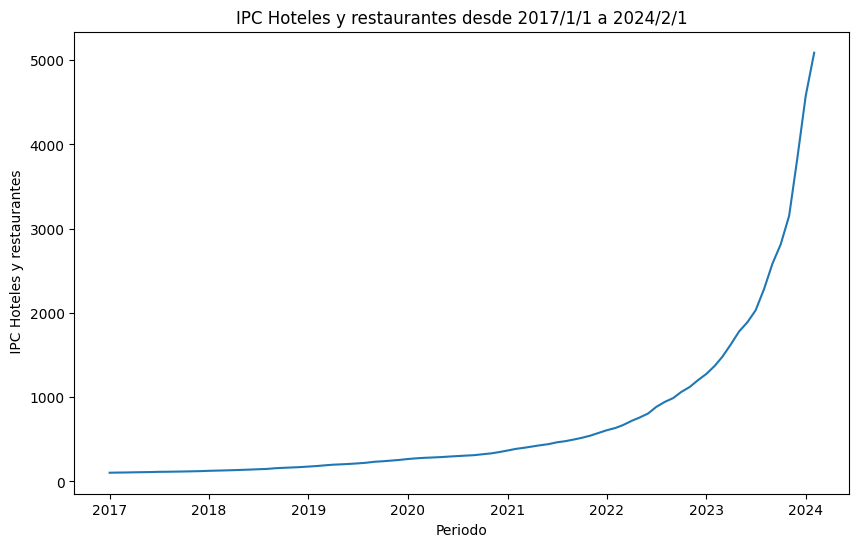

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(df3.index, df3)
plt.xlabel('Periodo')
plt.ylabel(' IPC Hoteles y restaurantes')
plt.title('IPC Hoteles y restaurantes desde 2017/1/1 a 2024/2/1')
plt.show()

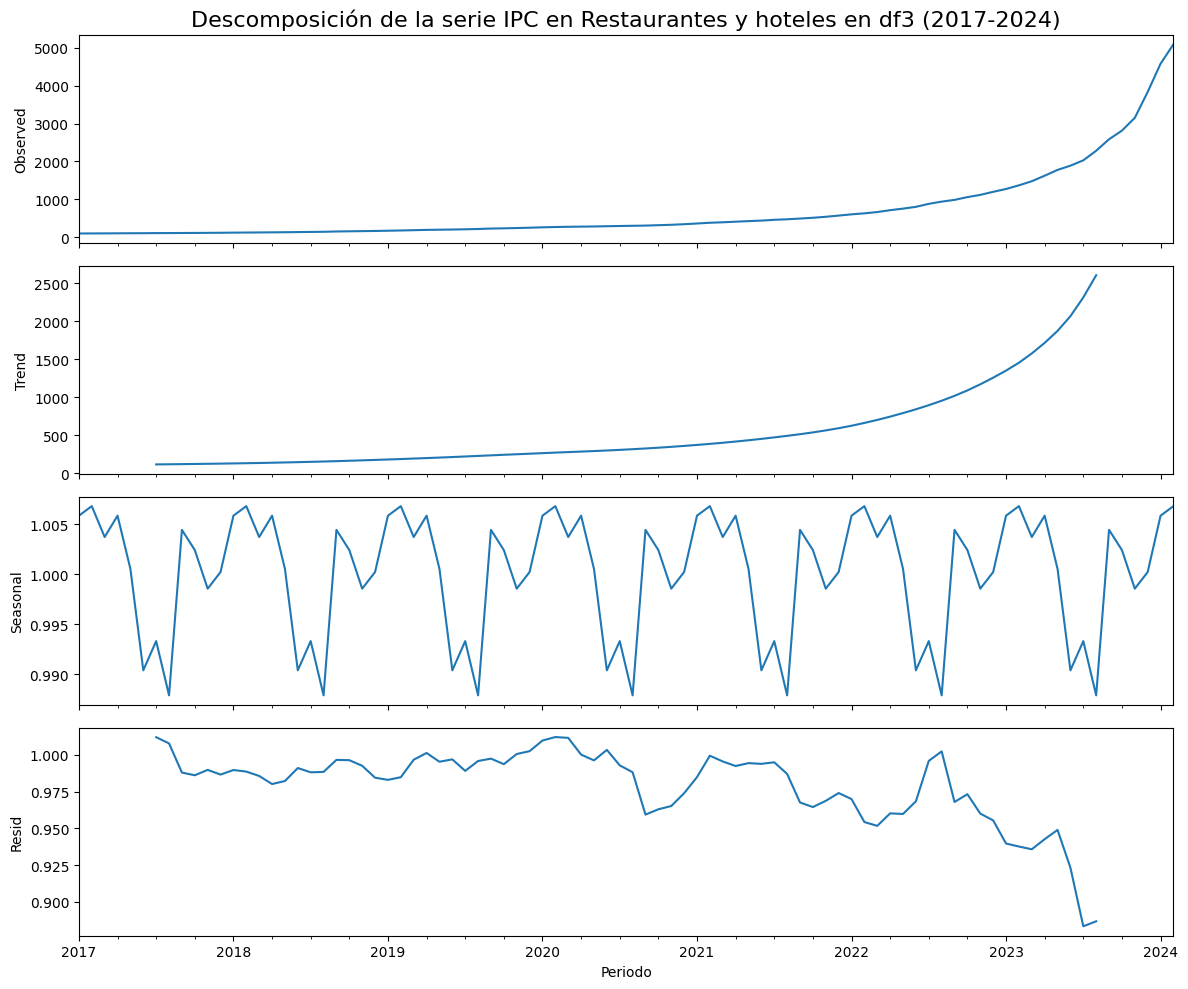

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

df3 = df3['2017-01-01':'2024-02-01'].copy()

# Aqui confirmamos una serie de fechas que tienen una frecuencia mensual comenzando el primer día de cada mes
df3.index.freq = 'MS'

result_df3 = seasonal_decompose(df3, model='multiplicative')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

result_df3.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
ax1.set_title('Descomposición de la serie IPC en Restaurantes y hoteles en df3 (2017-2024)', loc='center', fontsize=16)

result_df3.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

result_df3.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

result_df3.resid.plot(ax=ax4)
ax4.set_ylabel('Resid')

plt.xlabel('Periodo')
plt.tight_layout()
plt.show()

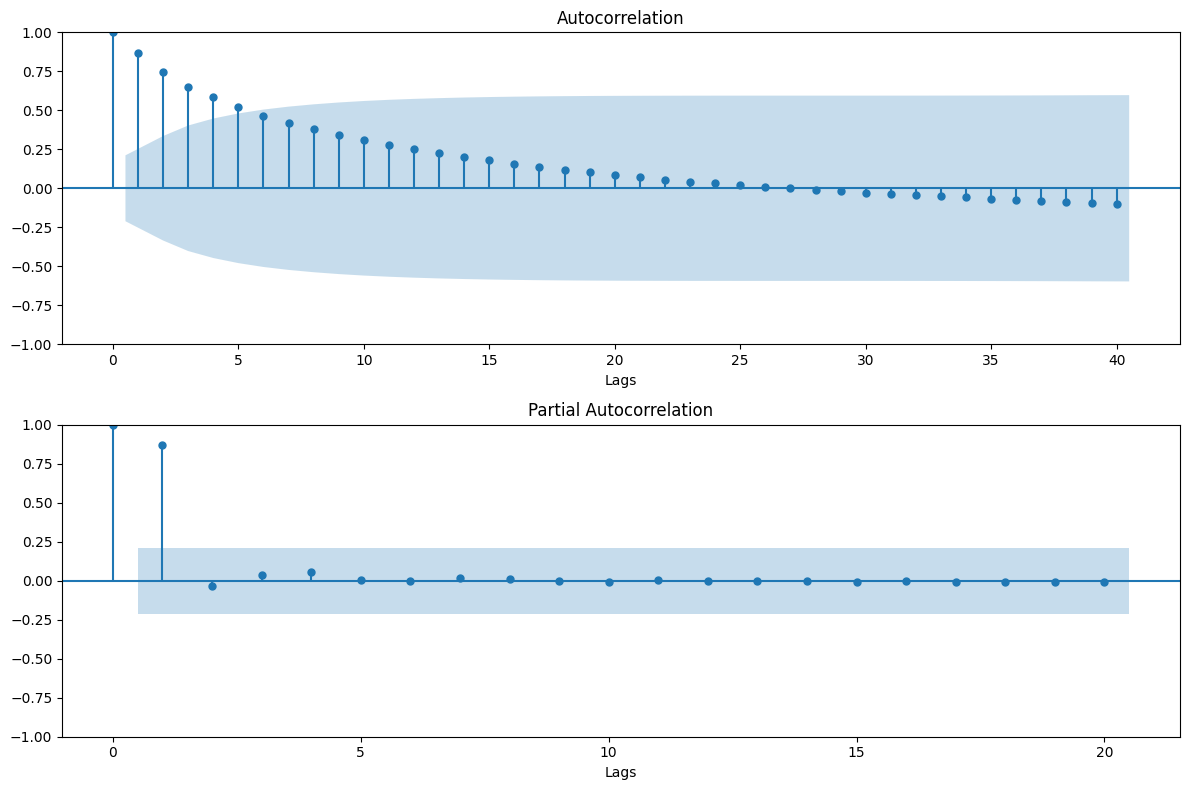

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df3, ax=ax1, lags=40)
ax1.set_xlabel('Lags')
plot_pacf(df3, ax=ax2, lags=20)
ax2.set_xlabel('Lags')
plt.tight_layout()
plt.show()

In [ ]:
#pruebas de raices unitarias


import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import ADFTest

# Aqui se define funcion para graficar restuldados del test ADF
def print_test_afd(y):
    resultado = adfuller(y)
    print('Estadistico ADF: %f' % resultado[0])
    print('p-valor: %f' % resultado[1])
    print('Valores criticos:')
    for key, valor in resultado[4].items():
        print('\t%s: %.3f' % (key, valor))

# Aqui se define la funcion para chequear estacionariedad
def test_stationarity(timeseries):

    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()


    fig = plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

# Se define aqui funcion para estimar el numero de diferencias
def estacionario(y):

    n_adf = ndiffs(y, test='adf')


    n_kpss = ndiffs(y, test='kpss')


    n_pp = ndiffs(y, test='pp')

    print('Estimado de número de diferencias con ADF test:', n_adf)
    print('Estimado de número de diferencias con KPSS test:', n_kpss)
    print('Estimado de número de diferencias con PP test:', n_pp)

    adftest = ADFTest(alpha=0.05)
    print('Se debe realizar diferenciación (should_diff) ADF Test:', adftest.should_diff(y))


Comentarios sobre la funcion " test_stationarity"

Si la media móvil y la desviación estándar móvil se mantienen relativamente constantes a lo largo del tiempo la serie puede ser estacionaria.
Si estas dos medidas muestran variaciones significativas puede la serie no ser estacionaria.

Este análisis gráfico no es concluyente pero es visualmente útil para observar la tendencia de la serie y su dispersión antes de aplicar pruebas formales de estacionariedad, como el ADF test

ADF Test Results for df3:
Estadistico ADF: -1.281896
p-valor: 0.637414
Valores criticos:
	1%: -3.523
	5%: -2.902
	10%: -2.588


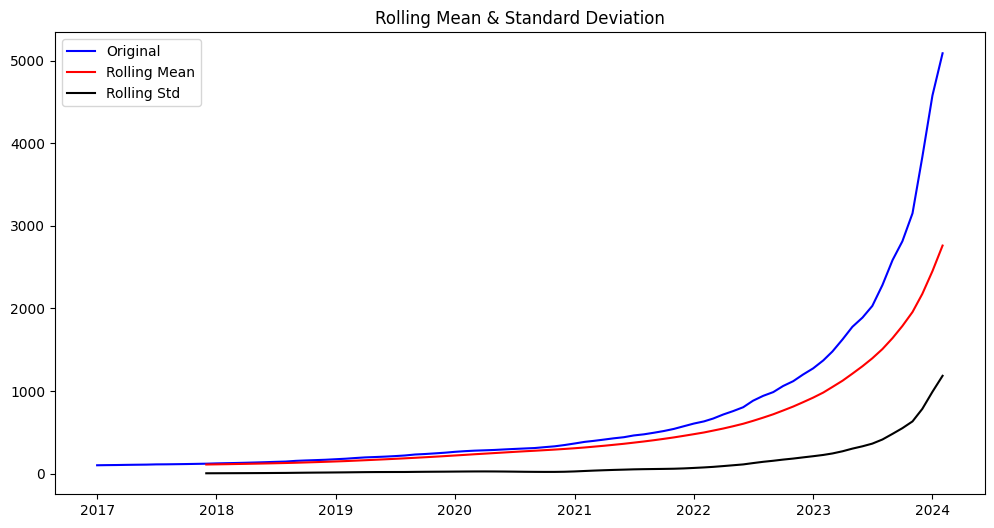

Estimation of number of differences for df3:
Estimado de número de diferencias con ADF test: 2
Estimado de número de diferencias con KPSS test: 2
Estimado de número de diferencias con PP test: 2
Se debe realizar diferenciación (should_diff) ADF Test: (0.41675632231590987, True)


In [ ]:
print("ADF Test Results for df3:")
print_test_afd(df3)
test_stationarity(df3)

print("Estimation of number of differences for df3:")
estacionario(df3)

Comentarios =

Estadístico ADF: -1.281896: Es el estadistico de la prueba. Donde la hipotesis nula indica que la serie es no estacionaria.

p-valor: 0.637414: Es la prob de aceptar la hipótesis nula, aqui no hay suficiente evidencia para rechazar la hipótesis nula, porque el p valor es mucho mayor a 0.05.

Diferentes valores de referencias, con los que comparamos el estadistico ADF.
1%: -3.523
5%: -2.902
10%: -2.58

Si el estadístico ADF es mas negativo entonces podemos rechazar la hipótesis nula con el nivel de confianza correspondiente.


In [ ]:
# ADF para la serie con "none" regression
adf_none_df3 = adfuller(df3, maxlag=None, regression='n', autolag='AIC', store=False, regresults=False)
print("\nADF Test Results for df3 (None regression):")
print('Estadistico ADF: %f' % adf_none_df3[0])
print('p-valor: %f' % adf_none_df3[1])
print('Valores criticos:')
for key, valor in adf_none_df3[4].items():
    print('\t%s: %.3f' % (key, valor))

# ADF test con Drift
adf_drift_df3 = adfuller(df3, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
print("\nADF Test Results for df3 (Drift regression):")
print('Estadistico ADF: %f' % adf_drift_df3[0])
print('p-valor: %f' % adf_drift_df3[1])
print('Valores criticos:')
for key, valor in adf_drift_df3[4].items():
    print('\t%s: %.3f' % (key, valor))

# ADF test con Trend
adf_trend_df3 = adfuller(df3, maxlag=None, regression='ct', autolag='AIC', store=False, regresults=False)
print("\nADF Test Results for df3 (Trend regression):")
print('Estadistico ADF: %f' % adf_trend_df3[0])
print('p-valor: %f' % adf_trend_df3[1])
print('Valores criticos:')
for key, valor in adf_trend_df3[4].items():
    print('\t%s: %.3f' % (key, valor))



ADF Test Results for df3 (None regression):
Estadistico ADF: -1.327422
p-valor: 0.170695
Valores criticos:
	1%: -2.597
	5%: -1.945
	10%: -1.614

ADF Test Results for df3 (Drift regression):
Estadistico ADF: -1.281896
p-valor: 0.637414
Valores criticos:
	1%: -3.523
	5%: -2.902
	10%: -2.588

ADF Test Results for df3 (Trend regression):
Estadistico ADF: 0.575342
p-valor: 0.996962
Valores criticos:
	1%: -4.088
	5%: -3.472
	10%: -3.163


Verificación de estacionaridad después de la diferenciación:


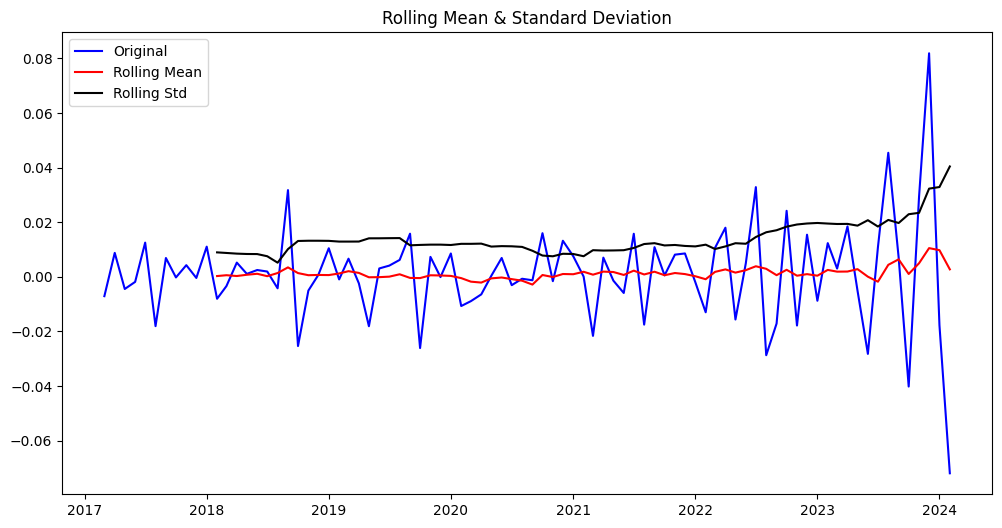

In [ ]:
# Transformaciones

df3_log = np.log(df3)
df3_diff = df3_log.diff().dropna()
df3_diff2 = df3_diff.diff().dropna()

# Verificar la estacionaridad después de la diferenciación
print("Verificación de estacionaridad después de la diferenciación:")
test_stationarity(df3_diff2)


In [ ]:
estacionario(df3_diff2)

Estimado de número de diferencias con ADF test: 0
Estimado de número de diferencias con KPSS test: 0
Estimado de número de diferencias con PP test: 0
Se debe realizar diferenciación (should_diff) ADF Test: (0.01, False)


In [ ]:
# Nuestro train test es 80/20 ( estos son otros parametros a analizar , aqui ponemos numeros por defecto)

train3 = df3_diff['2017-01-01':'2022-12-31']
test3 = df3_diff['2023-01-01':'2024-02-01']

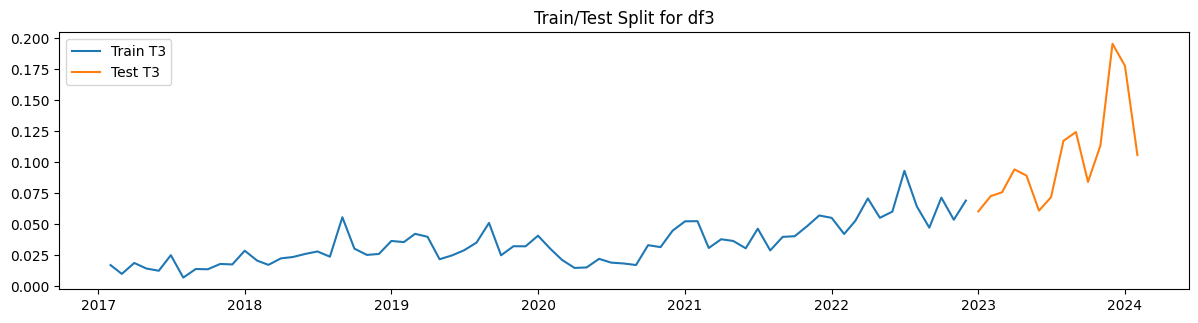

In [ ]:
plt.figure(figsize=(12, 9))



# Plotting train and test for df3
plt.subplot(3, 1, 3)
plt.plot(train3, label='Train T3')
plt.plot(test3, label='Test T3')
plt.title('Train/Test Split for df3')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

def autocov_autocorr(data, maxlag):
    autocov = sm.tsa.acovf(data, unbiased=True, fft=True, missing='conservative', nlag=maxlag)
    autocorr = sm.tsa.acf(data, fft=True, nlags=maxlag)
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.plot(autocov)
    plt.title('Autocovariance')
    plt.subplot(122)
    plt.plot(autocorr)
    plt.title('Autocorrelation')
    plt.tight_layout()
    plt.show()

def componentes(data):
    decomposition = sm.tsa.seasonal_decompose(data, model='additive')
    fig = decomposition.plot()
    fig.set_size_inches(10, 6)
    plt.tight_layout()
    plt.show()

def evaluar_metricas(serie_test, serie_pred):
    print(f'MSE: {mean_squared_error(serie_test, serie_pred)}')
    print(f'MAE: {mean_absolute_error(serie_test, serie_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(serie_test, serie_pred))}')
    print(f'MAPE: {round(np.mean(abs((serie_test-serie_pred)/serie_test)),4)}')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluar_metricas(serie_test, serie_pred):
    mse = mean_squared_error(serie_test, serie_pred)
    mae = mean_absolute_error(serie_test, serie_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((serie_test - serie_pred) / serie_test))

    if np.isinf(mape) or np.isnan(mape):
        mape = np.nan

    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {round(mape, 4)}')


<ipython-input-57-796105879b50>:10: FutureWarning: the 'unbiased' keyword is deprecated, use 'adjusted' instead.
  autocov = sm.tsa.acovf(data, unbiased=True, fft=True, missing='conservative', nlag=maxlag)


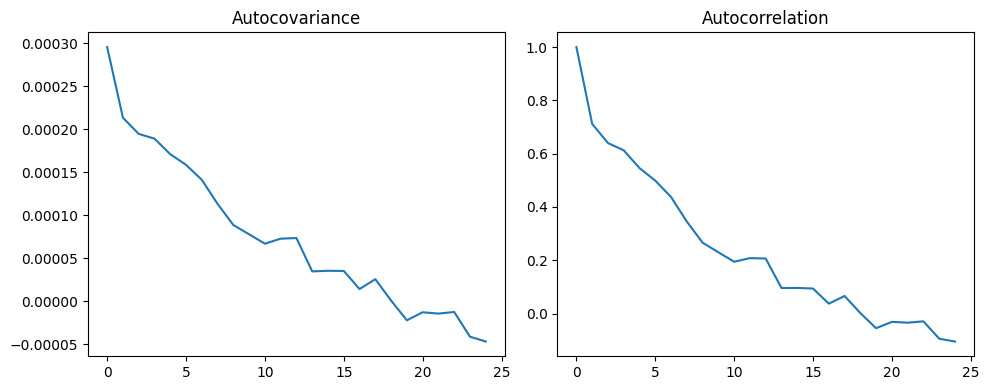

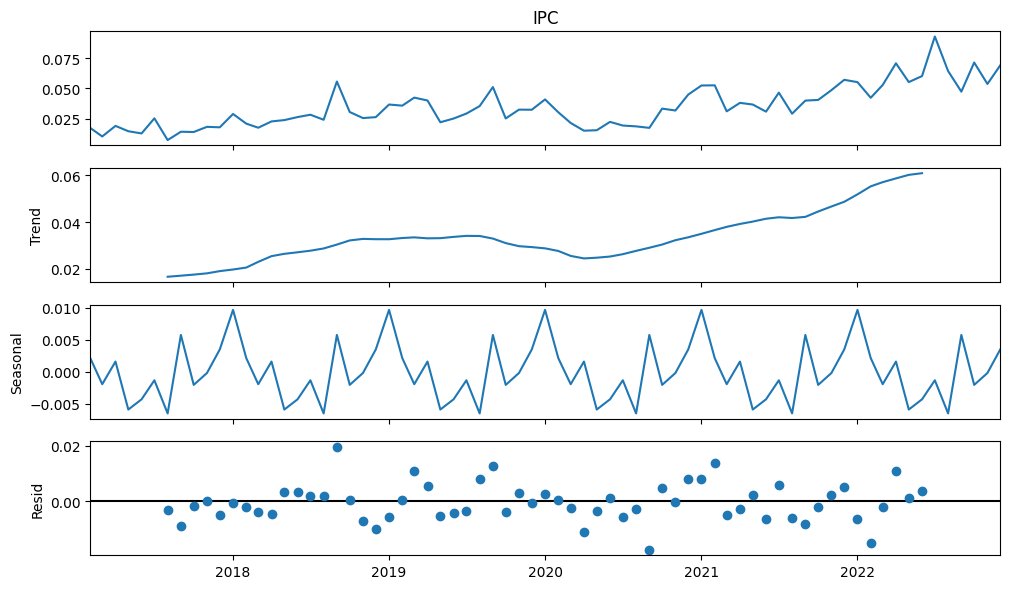

In [ ]:
autocov_autocorr(train3, 24)
componentes(train3)

In [ ]:
from pmdarima.arima import auto_arima

stepwise_fit = auto_arima(train3, start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=1, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-340.592, Time=2.86 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-325.798, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-332.667, Time=0.37 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-341.556, Time=0.64 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-335.436, Time=0.19 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-341.058, Time=1.06 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-341.033, Time=1.88 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-337.493, Time=0.56 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-339.319, Time=2.21 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-331.172, Time=0.30 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-340.934, Time=0.84 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-335.486, Time=0.31 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-339.009, Time=1.24 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-339.744, Time=1.27 sec

Best model:  ARIMA

In [ ]:
from pmdarima.arima import auto_arima

stepwise_fit = auto_arima(train3, start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=False,
                          d=1, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

print(stepwise_fit.summary())

Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-431.996, Time=1.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-413.289, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-423.280, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-433.718, Time=1.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-415.034, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-432.300, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-430.767, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-432.965, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 3.485 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   71
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 219.859
Date:                Tue, 08 Oct 2024   AIC                           -433.718
Time:                        17:56:16   BIC                           -426.972


                               SARIMAX Results                                
Dep. Variable:                    IPC   No. Observations:                   71
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 218.482
Date:                Tue, 08 Oct 2024   AIC                           -432.965
Time:                        17:56:17   BIC                           -428.468
Sample:                    02-01-2017   HQIC                          -431.178
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5522      0.103     -5.373      0.000      -0.754      -0.351
sigma2         0.0001   1.58e-05      7.170      0.000    8.23e-05       0.000
Ljung-Box (L1) (Q):                   0.20   Jarque-

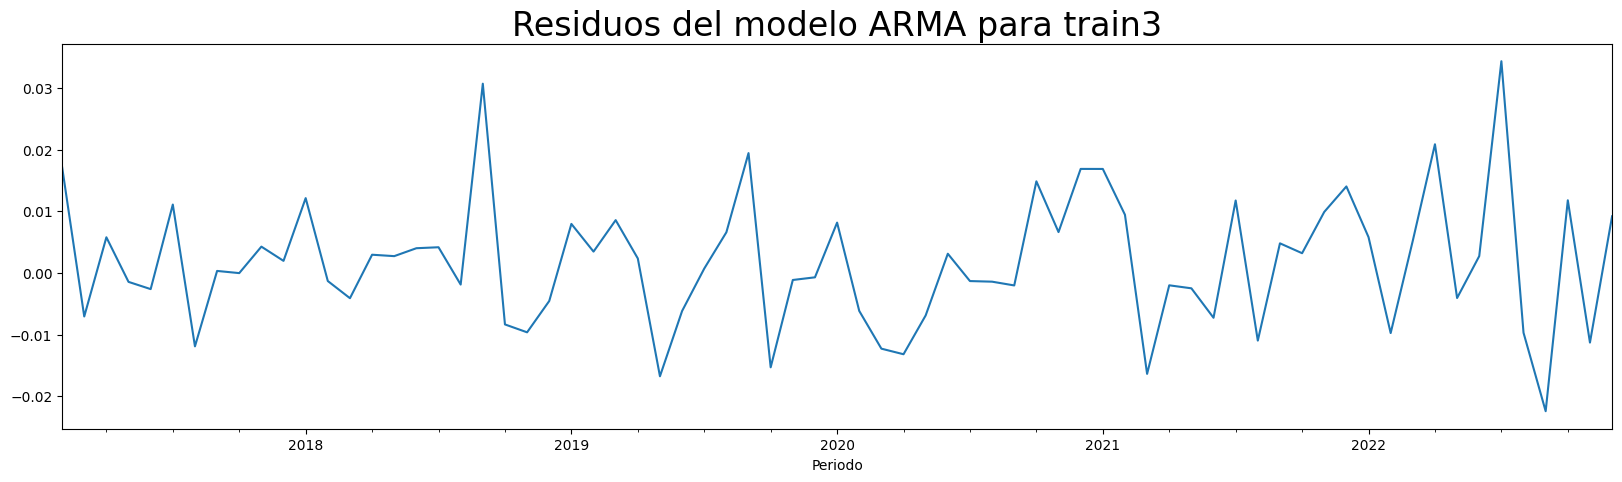

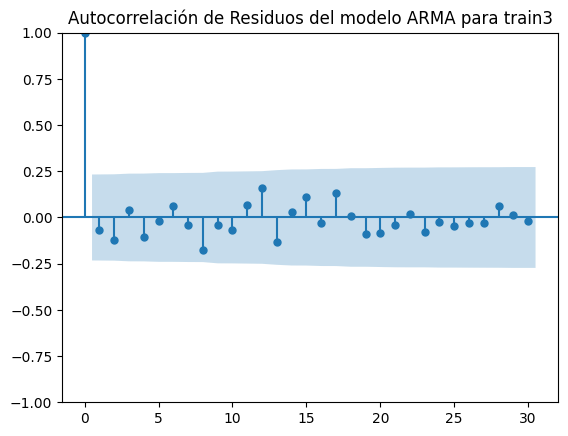

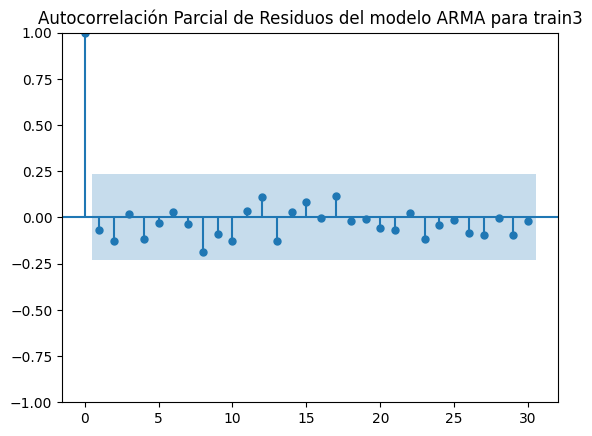

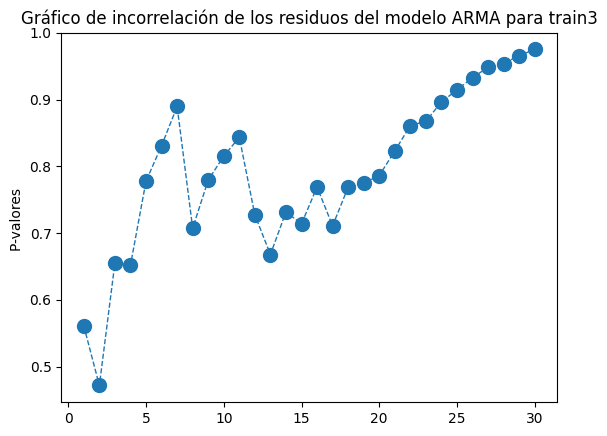

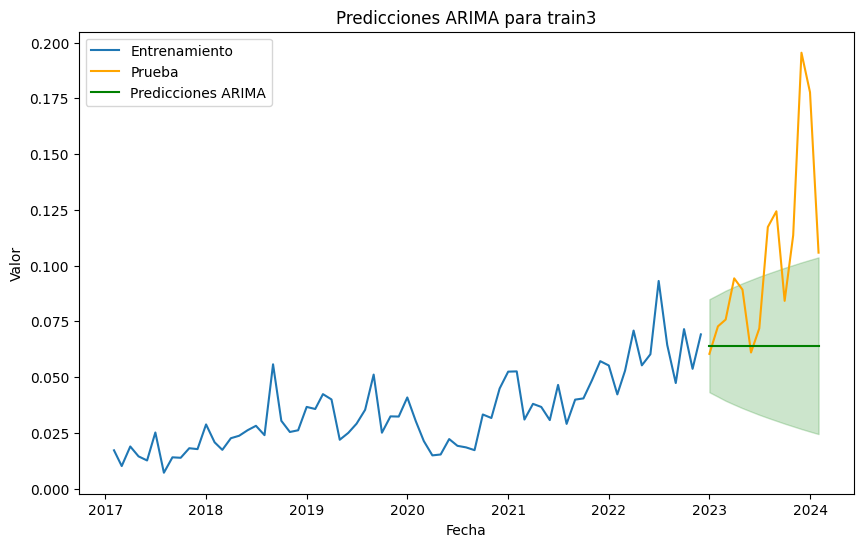

MSE: 0.003076515261156358
MAE: 0.04000688284483166
RMSE: 0.05546634349906579
MAPE: 0.3153


In [ ]:
modeloARMA_train3 = ARIMA(train3, order=(0, 1, 1))
resultadoARMA_train3 = modeloARMA_train3.fit()

print(resultadoARMA_train3.summary())

resultadoARMA_train3.resid.plot(figsize=(20, 5))
plt.title("Residuos del modelo ARMA para train3", size=24)
plt.show()

sm.graphics.tsa.plot_acf(resultadoARMA_train3.resid, lags=30)
plt.title("Autocorrelación de Residuos del modelo ARMA para train3")
plt.show()

sm.graphics.tsa.plot_pacf(resultadoARMA_train3.resid, lags=30)
plt.title("Autocorrelación Parcial de Residuos del modelo ARMA para train3")
plt.show()

Incorr_residuos_modelo_ARMA_train3 = sm.stats.acorr_ljungbox(resultadoARMA_train3.resid, lags=30)
plt.plot(Incorr_residuos_modelo_ARMA_train3.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
plt.title("Gráfico de incorrelación de los residuos del modelo ARMA para train3")
plt.ylabel("P-valores ")
plt.show()

prediccionesARIMA_train3 = resultadoARMA_train3.get_forecast(steps=len(test3))
pred_train3 = prediccionesARIMA_train3.predicted_mean
conf_int = prediccionesARIMA_train3.conf_int()

plt.figure(figsize=(10, 6))
plt.plot(train3.index, train3, label='Entrenamiento')
plt.plot(test3.index, test3, label='Prueba', color='orange')
plt.plot(test3.index, pred_train3, label='Predicciones ARIMA', color='green')
plt.fill_between(test3.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)
plt.title('Predicciones ARIMA para train3')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

evaluar_metricas(test3, pred_train3)

                                     SARIMAX Results                                      
Dep. Variable:                                IPC   No. Observations:                   71
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 173.778
Date:                            Tue, 08 Oct 2024   AIC                           -341.556
Time:                                    17:56:19   BIC                           -335.375
Sample:                                02-01-2017   HQIC                          -339.149
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5830      0.106     -5.480      0.000      -0.791      -0.374
ma.S.L12      -0.6147      0.196   

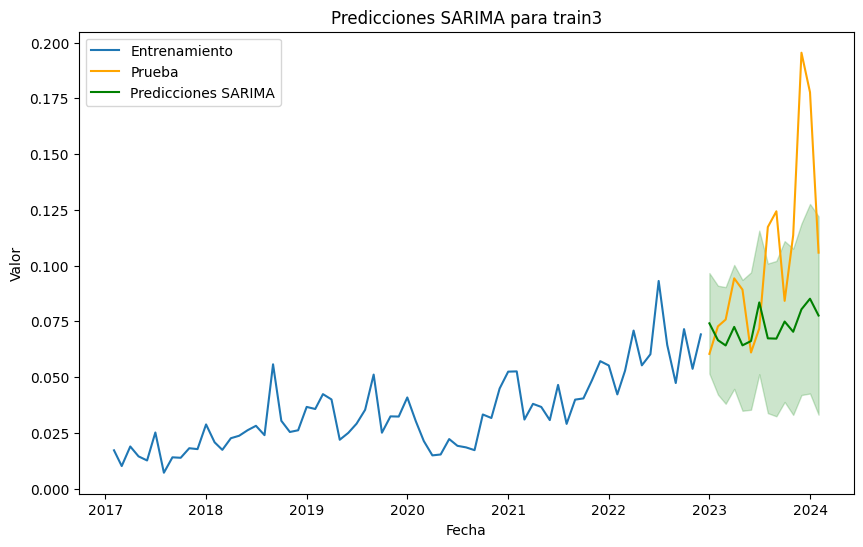

 modelo  SARIMA (0,1,1)(0,1,1)[12]
 
MSE: 0.002280426800075636
MAE: 0.03502640745660057
RMSE: 0.047753814508116894
MAPE: 0.2838


In [ ]:
modeloSARIMA_train3 = SARIMAX(train3, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
modeloSARIMA_fit_train3 = modeloSARIMA_train3.fit()

print(modeloSARIMA_fit_train3.summary())

prediccionesSARIMA_train3 = modeloSARIMA_fit_train3.get_forecast(steps=len(test3))

plt.figure(figsize=(10, 6))
plt.plot(train3.index, train3, label='Entrenamiento')
plt.plot(test3.index, test3, label='Prueba', color='orange')
plt.plot(test3.index, prediccionesSARIMA_train3.predicted_mean, label='Predicciones SARIMA', color='green')
plt.fill_between(test3.index, prediccionesSARIMA_train3.conf_int().iloc[:, 0], prediccionesSARIMA_train3.conf_int().iloc[:, 1], color='green', alpha=0.2)
plt.title('Predicciones SARIMA para train3')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()


print( " modelo  SARIMA (0,1,1)(0,1,1)[12]")
print ( " ")
sarima_metrics = evaluar_metricas(test3, prediccionesSARIMA_train3.predicted_mean)


Modelo ARIMA(0, 1, 1)

MSE: 0.003076515261156358 <br>
MAE: 0.04000688284483166 <br>
RMSE: 0.05546634349906579 <br>
MAPE: 0.3153


"El modelo SARIMA es mejor que el modelo ARIMA , porque tiene metricas de error mas bajas en todas las categorias analizadas. Entonces,  se ajusta mejor a los datos y produce predicciones más precisas"

In [ ]:
# Nuestro train test es 80/20

train3_original = df3['2017-01-01':'2022-12-31']
test3_original = df3['2023-01-01':'2024-02-01']

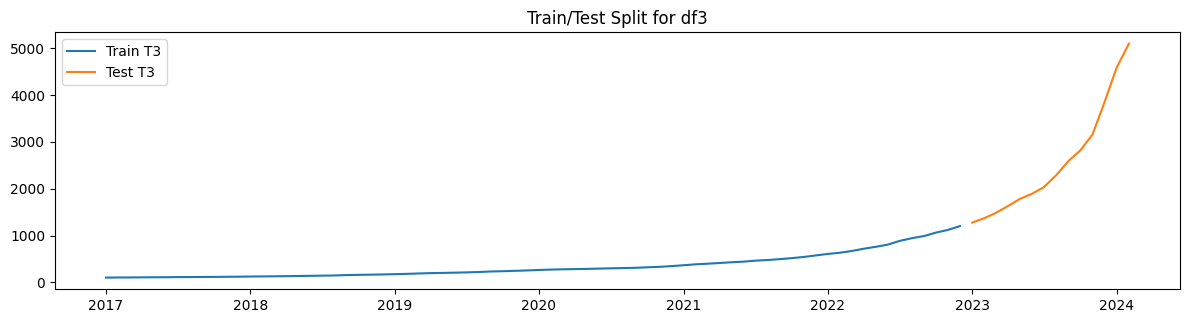

In [ ]:
plt.figure(figsize=(12, 9))



plt.subplot(3, 1, 3)
plt.plot(train3_original, label='Train T3')
plt.plot(test3_original, label='Test T3')
plt.title('Train/Test Split for df3')
plt.legend()

plt.tight_layout()
plt.show()




In [ ]:

from pmdarima.arima import auto_arima

stepwise_fit = auto_arima(train3_original, start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=1, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

print(stepwise_fit.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=404.177, Time=0.36 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=506.702, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=416.897, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=468.166, Time=0.18 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=402.250, Time=0.10 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=404.164, Time=0.23 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.93 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=415.367, Time=0.05 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=403.243, Time=0.15 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=401.587, Time=0.14 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=403.542, Time=0.31 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=403.545, Time=1.23 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=405.519, Time=0.77 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AI

In [ ]:

from pmdarima.arima import auto_arima

stepwise_fit = auto_arima(train3_original, start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=False,
                          d=1, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

print(stepwise_fit.summary())

Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=483.387, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=623.637, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=495.661, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=563.985, Time=1.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=657.698, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=484.285, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=481.592, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=554.375, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=474.681, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=526.429, Time=0.23 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=475.960, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=473.575, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=480.445, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                    IPC   No. Observations:                   72
Model:                 ARIMA(1, 1, 3)   Log Likelihood                -231.787
Date:                Tue, 08 Oct 2024   AIC                            473.575
Time:                        17:56:33   BIC                            484.888
Sample:                    01-01-2017   HQIC                           478.074
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9955      0.009    105.840      0.000       0.977       1.014
ma.L1         -0.4694      0.089     -5.279      0.000      -0.644      -0.295
ma.L2         -0.3822      0.136     -2.819      0.0

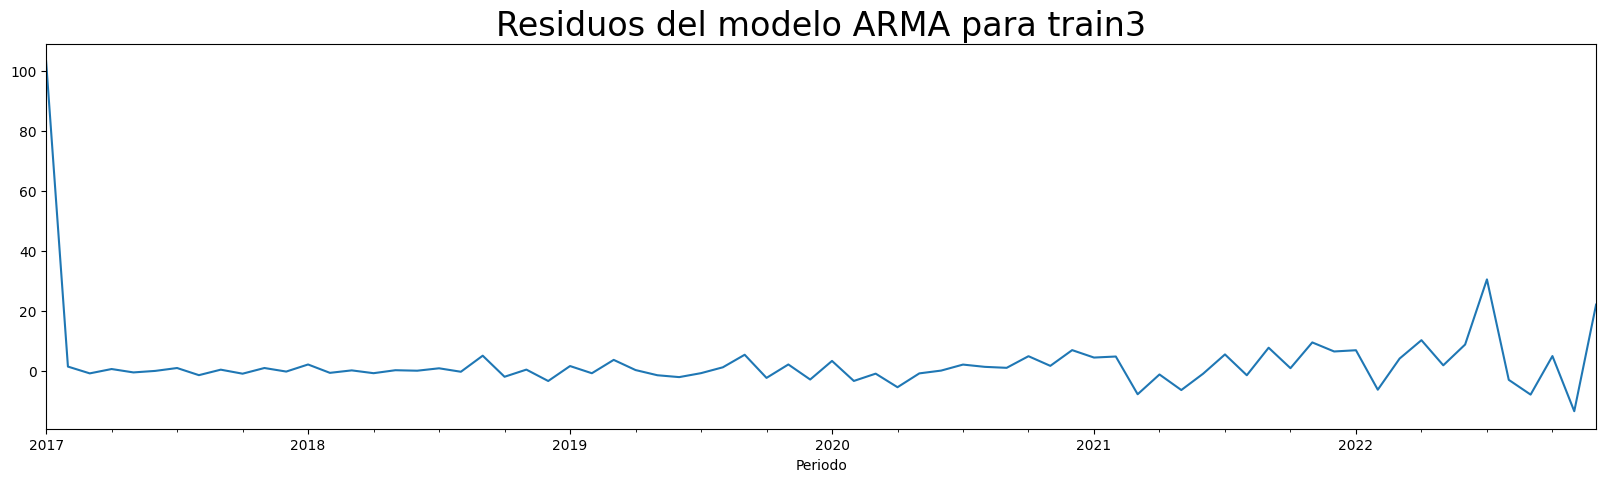

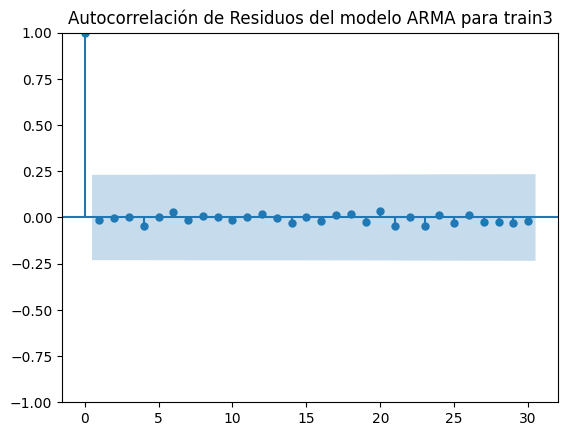

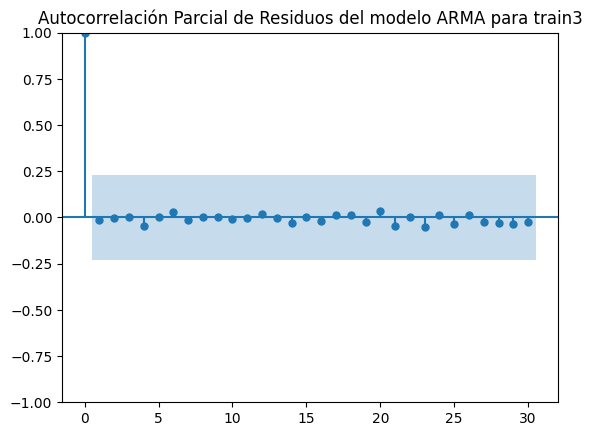

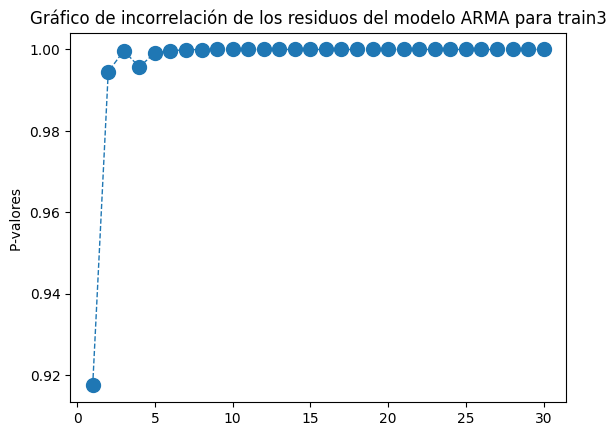

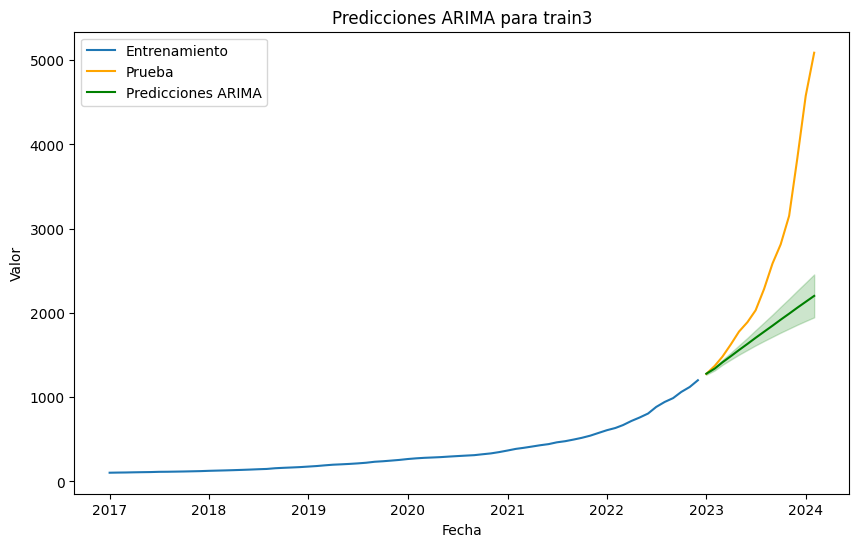

MSE: 1474217.2764186896
MAE: 817.6851786987028
RMSE: 1214.1734951886776
MAPE: 0.2382


In [ ]:
modeloARMA_train3 = ARIMA(train3_original, order=(1, 1, 3))
resultadoARMA_train3 = modeloARMA_train3.fit()

print(resultadoARMA_train3.summary())

resultadoARMA_train3.resid.plot(figsize=(20, 5))
plt.title("Residuos del modelo ARMA para train3", size=24)
plt.show()

sm.graphics.tsa.plot_acf(resultadoARMA_train3.resid, lags=30)
plt.title("Autocorrelación de Residuos del modelo ARMA para train3")
plt.show()

sm.graphics.tsa.plot_pacf(resultadoARMA_train3.resid, lags=30)
plt.title("Autocorrelación Parcial de Residuos del modelo ARMA para train3")
plt.show()

Incorr_residuos_modelo_ARMA_train3 = sm.stats.acorr_ljungbox(resultadoARMA_train3.resid, lags=30)
plt.plot(Incorr_residuos_modelo_ARMA_train3.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
plt.title("Gráfico de incorrelación de los residuos del modelo ARMA para train3")
plt.ylabel("P-valores ")
plt.show()

prediccionesARIMA_train3 = resultadoARMA_train3.get_forecast(steps=len(test3_original))
pred_train3 = prediccionesARIMA_train3.predicted_mean
conf_int = prediccionesARIMA_train3.conf_int()

plt.figure(figsize=(10, 6))
plt.plot(train3_original.index, train3_original, label='Entrenamiento')
plt.plot(test3_original.index, test3_original, label='Prueba', color='orange')
plt.plot(test3_original.index, pred_train3, label='Predicciones ARIMA', color='green')
plt.fill_between(test3_original.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)
plt.title('Predicciones ARIMA para train3')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

evaluar_metricas(test3_original, pred_train3)

                                      SARIMAX Results                                      
Dep. Variable:                                 IPC   No. Observations:                   72
Model:             SARIMAX(1, 1, 2)x(0, 1, [], 12)   Log Likelihood                -196.793
Date:                             Tue, 08 Oct 2024   AIC                            401.587
Time:                                     17:56:35   BIC                            409.897
Sample:                                 01-01-2017   HQIC                           404.831
                                      - 12-01-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9890      0.020     48.660      0.000       0.949       1.029
ma.L1         -0.6956      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


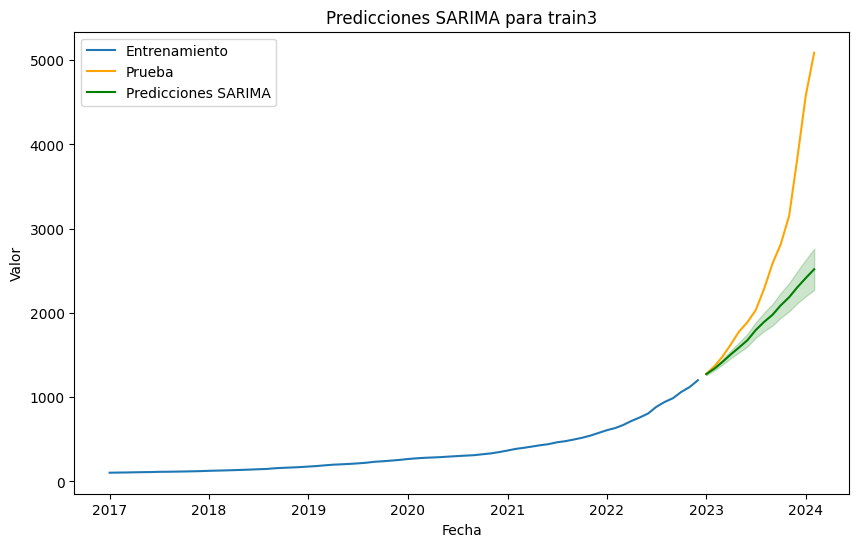

 modelo  SARIMA (1,1,2)(0,1,0)[12]
 
MSE: 1125692.8377723496
MAE: 700.2984740424606
RMSE: 1060.9867283676783
MAPE: 0.2015


In [ ]:
modeloSARIMA_train3 = SARIMAX(train3_original, order=(1, 1, 2), seasonal_order=(0, 1, 0, 12))
modeloSARIMA_fit_train3 = modeloSARIMA_train3.fit()

print(modeloSARIMA_fit_train3.summary())

prediccionesSARIMA_train3 = modeloSARIMA_fit_train3.get_forecast(steps=len(test3_original))

plt.figure(figsize=(10, 6))
plt.plot(train3_original.index, train3_original, label='Entrenamiento')
plt.plot(test3_original.index, test3_original, label='Prueba', color='orange')
plt.plot(test3_original.index, prediccionesSARIMA_train3.predicted_mean, label='Predicciones SARIMA', color='green')
plt.fill_between(test3_original.index, prediccionesSARIMA_train3.conf_int().iloc[:, 0], prediccionesSARIMA_train3.conf_int().iloc[:, 1], color='green', alpha=0.2)
plt.title('Predicciones SARIMA para train3')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()


print( " modelo  SARIMA (1,1,2)(0,1,0)[12]")
print ( " ")
sarima_metrics = evaluar_metricas(test3_original, prediccionesSARIMA_train3.predicted_mean)



Orden de los modelos de mejor a peor: <br>
Modelo SARIMA (0,1,1)(0,1,1)[12] (mejor rendimiento en todas las métricas) <br>
Modelo ARIMA(0, 1, 1)  <br>
Modelo SARIMA (1,1,2)(0,1,0)[12] explosivo  <br>
Modelo ARIMA explosivo (peor rendimiento en todas las métricas)  <br>

In [ ]:
# trabajamos con la copia que habiamos hecho para el modelo SARIMAX

columnas_df3copy = df3copy.columns
print(columnas_df3copy)

df3copy.rename(columns={'Total nacional': 'Periodo'}, inplace=True)

df3copy.rename(columns={'Restaurantes y hoteles': 'IPC'}, inplace=True)

columns_to_drop = ['Unnamed: 4', 'Categorías ', 'Estacional', 'Núcleo', 'Regulados', 'Unnamed: 9', 'Nivel general' , 'Bienes y servicios']
df3copy.drop(columns=columns_to_drop, inplace=True)

df3copy.rename(columns={'Alimentos y bebidas no alcohólicas': 'AlimentosBebidas'}, inplace=True)

print(df3copy.columns)


Index(['Total nacional', 'Nivel general', 'Alimentos y bebidas no alcohólicas',
       'Restaurantes y hoteles', 'Unnamed: 4', 'Categorías ', 'Estacional',
       'Núcleo', 'Regulados', 'Unnamed: 9', 'Bienes y servicios', 'Bienes',
       'Servicios'],
      dtype='object')
Index(['Periodo', 'AlimentosBebidas', 'IPC', 'Bienes', 'Servicios'], dtype='object')


In [ ]:
df_alimentos_bebidas = df3copy[['Periodo', 'AlimentosBebidas']].copy()
df_bienes = df3copy[['Periodo', 'Bienes']].copy()
df_servicios = df3copy[['Periodo', 'Servicios']].copy()
df3_IPC= df3copy[['Periodo', 'IPC']].copy()

print("Columnas de df3copy después de la transformación:")
print(df3copy.columns)

print("\nPrimeros registros de df_alimentos_bebidas:")
print(df_alimentos_bebidas.head())

print("\nPrimeros registros de df_bienes:")
print(df_bienes.head())

print("\nPrimeros registros de df_servicios:")
print(df_servicios.head())

Columnas de df3copy después de la transformación:
Index(['Periodo', 'AlimentosBebidas', 'IPC', 'Bienes', 'Servicios'], dtype='object')

Primeros registros de df_alimentos_bebidas:
     Periodo  AlimentosBebidas
0 2016-12-01          100.0000
1 2017-01-01          101.3024
2 2017-02-01          103.1605
3 2017-03-01          106.0143
4 2017-04-01          108.3515

Primeros registros de df_bienes:
     Periodo    Bienes
0 2016-12-01  100.0000
1 2017-01-01  101.1903
2 2017-02-01  102.7002
3 2017-03-01  104.9817
4 2017-04-01  107.4919

Primeros registros de df_servicios:
     Periodo  Servicios
0 2016-12-01   100.0000
1 2017-01-01   102.4355
2 2017-02-01   105.5426
3 2017-03-01   108.6229
4 2017-04-01   112.0904


In [ ]:
import pandas as pd


print(f"Hay valores nulos en df_alimentos_bebidas: {df_alimentos_bebidas.isnull().values.any()}")
print(f"Hay valores nulos en df_bienes: {df_bienes.isnull().values.any()}")
print(f"Hay valores nulos en df_servicios: {df_servicios.isnull().values.any()}")

if not pd.api.types.is_datetime64_any_dtype(df_alimentos_bebidas['Periodo']):
    df_alimentos_bebidas['Periodo'] = pd.to_datetime(df_alimentos_bebidas['Periodo'])

if not pd.api.types.is_datetime64_any_dtype(df_bienes['Periodo']):
    df_bienes['Periodo'] = pd.to_datetime(df_bienes['Periodo'])

if not pd.api.types.is_datetime64_any_dtype(df_servicios['Periodo']):
    df_servicios['Periodo'] = pd.to_datetime(df_servicios['Periodo'])

# Establecer 'Periodo' como índice
df_alimentos_bebidas.set_index('Periodo', inplace=True)
df_bienes.set_index('Periodo', inplace=True)
df_servicios.set_index('Periodo', inplace=True)

df_alimentos_bebidas_subset = df_alimentos_bebidas
df_bienes_subset = df_bienes
df_servicios_subset = df_servicios

df_alimentos_bebidas_subset.index.freq = 'MS'
df_bienes_subset.index.freq = 'MS'
df_servicios_subset.index.freq = 'MS'

# Verificar los resultados
print("\nPrimeros registros de df_alimentos_bebidas_subset:")
print(df_alimentos_bebidas_subset.head())

print("\nPrimeros registros de df_bienes_subset:")
print(df_bienes_subset.head())

print("\nPrimeros registros de df_servicios_subset:")
print(df_servicios_subset.head())

# Verificar si hay valores nulos en df3_IPC
print(f"Hay valores nulos en df3_IPC: {df3_IPC.isnull().values.any()}")

# Convertir 'Periodo' a tipo datetime si no lo está
if not pd.api.types.is_datetime64_any_dtype(df3_IPC['Periodo']):
    df3_IPC['Periodo'] = pd.to_datetime(df3_IPC['Periodo'])

# Establecer 'Periodo' como índice
df3_IPC.set_index('Periodo', inplace=True)

# Seleccionar el rango de fechas deseado y establecer frecuencia
df3_IPC_subset = df3_IPC['2017-01-01':'2024-02-01'].copy()
df3_IPC_subset.index.freq = 'MS'

Hay valores nulos en df_alimentos_bebidas: False
Hay valores nulos en df_bienes: False
Hay valores nulos en df_servicios: False

Primeros registros de df_alimentos_bebidas_subset:
            AlimentosBebidas
Periodo                     
2016-12-01          100.0000
2017-01-01          101.3024
2017-02-01          103.1605
2017-03-01          106.0143
2017-04-01          108.3515

Primeros registros de df_bienes_subset:
              Bienes
Periodo             
2016-12-01  100.0000
2017-01-01  101.1903
2017-02-01  102.7002
2017-03-01  104.9817
2017-04-01  107.4919

Primeros registros de df_servicios_subset:
            Servicios
Periodo              
2016-12-01   100.0000
2017-01-01   102.4355
2017-02-01   105.5426
2017-03-01   108.6229
2017-04-01   112.0904
Hay valores nulos en df3_IPC: False


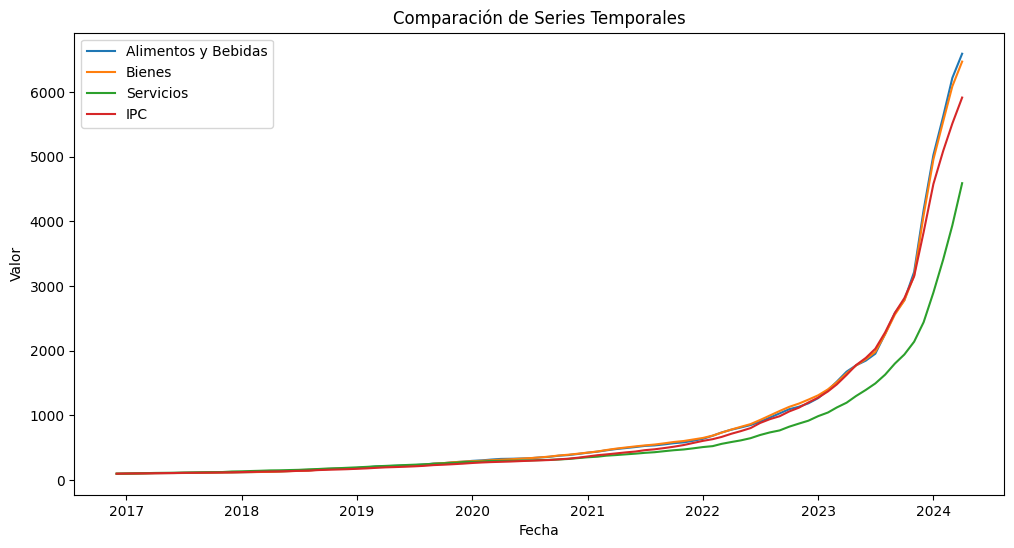

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(df_alimentos_bebidas_subset['AlimentosBebidas'], label='Alimentos y Bebidas')

plt.plot(df_bienes_subset['Bienes'], label='Bienes')

plt.plot(df_servicios_subset['Servicios'], label='Servicios')

plt.plot(df3_IPC['IPC'], label='IPC')

plt.legend()
plt.title('Comparación de Series Temporales')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.show()

Este código esta haciendo un analisis de correlación cruzada  entre la serie temporal del IPC y tres otras series temporales Alimentos y Bebidas, Bienes, y Servicios.

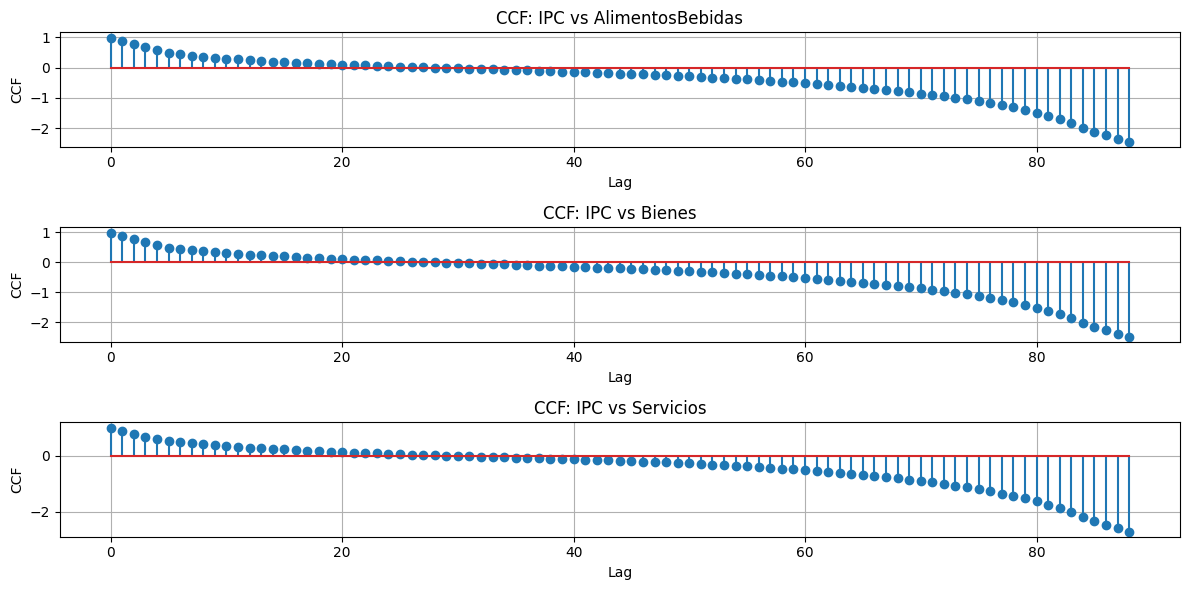

In [ ]:
from statsmodels.tsa.stattools import ccf
import matplotlib.pyplot as plt

Bienes_array = df3copy['Bienes'].values
Servicios_array = df3copy['Servicios'].values
AlimentosBebidas_array = df3copy['AlimentosBebidas'].values
IPC_array = df3copy['IPC'].values

ccf_IPC_AlimentosBebidas = ccf(IPC_array, AlimentosBebidas_array)
ccf_IPC_Bienes = ccf(IPC_array, Bienes_array)
ccf_IPC_Servicios = ccf(IPC_array, Servicios_array)

plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.stem(ccf_IPC_AlimentosBebidas)
plt.title('CCF: IPC vs AlimentosBebidas')
plt.xlabel('Lag')
plt.ylabel('CCF')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.stem(ccf_IPC_Bienes)
plt.title('CCF: IPC vs Bienes')
plt.xlabel('Lag')
plt.ylabel('CCF')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.stem(ccf_IPC_Servicios)
plt.title('CCF: IPC vs Servicios')
plt.xlabel('Lag')
plt.ylabel('CCF')
plt.grid(True)

plt.tight_layout()
plt.show()

Aqui lo que hace es calcular la correlacion cruzada entre el IPC y las otras series temporales . Asi vemos información sobre como se relacionan estas variables en el tiempo y si un cambio en el IPC puede estar asociado con cambios en Alimentos y Bebidas, Bienes o Servicios.

In [ ]:
lags = 20

ccf_IPC_AlimentosBebidas = ccf(IPC_array, AlimentosBebidas_array)[:lags]

ccf_IPC_Bienes = ccf(IPC_array, Bienes_array)[:lags]

ccf_IPC_Servicios = ccf(IPC_array, Servicios_array)[:lags]

print("Cross-Correlation Function (CCF) between IPC and AlimentosBebidas:")
for lag, ccf_value in enumerate(ccf_IPC_AlimentosBebidas):
    print(f"Lag {lag}: {ccf_value}")

print("\nCross-Correlation Function (CCF) between IPC and Bienes:")
for lag, ccf_value in enumerate(ccf_IPC_Bienes):
    print(f"Lag {lag}: {ccf_value}")

print("\nCross-Correlation Function (CCF) between IPC and Servicios:")
for lag, ccf_value in enumerate(ccf_IPC_Servicios):
    print(f"Lag {lag}: {ccf_value}")

Cross-Correlation Function (CCF) between IPC and AlimentosBebidas:
Lag 0: 0.998393052499014
Lag 1: 0.8906749856710028
Lag 2: 0.7775352444901892
Lag 3: 0.6699695039047444
Lag 4: 0.5703581280615136
Lag 5: 0.4907692305234389
Lag 6: 0.4389514818303884
Lag 7: 0.39738947701554594
Lag 8: 0.35769371447164583
Lag 9: 0.32557843831646976
Lag 10: 0.30118646517326675
Lag 11: 0.27686470920666945
Lag 12: 0.2514449112956369
Lag 13: 0.22625014504509358
Lag 14: 0.2042556704620091
Lag 15: 0.184854424778123
Lag 16: 0.16811767865981916
Lag 17: 0.15235058537222065
Lag 18: 0.13644704537800448
Lag 19: 0.11984407104586399

Cross-Correlation Function (CCF) between IPC and Bienes:
Lag 0: 0.998765273187854
Lag 1: 0.8922675101490719
Lag 2: 0.781186526332988
Lag 3: 0.674233260164045
Lag 4: 0.575323012155014
Lag 5: 0.49772895178215887
Lag 6: 0.44778746919707474
Lag 7: 0.4062572206891105
Lag 8: 0.3674391407131125
Lag 9: 0.33561318745836494
Lag 10: 0.31030544529401927
Lag 11: 0.2854987568388262
Lag 12: 0.2608163125435

los valores que estan muy cerca de 1 indica una fuerte correlacion.

vemos fuertes Relaciones inmediatas porque todas las categorías tienen una fuerte relación con el IPC en el presente y se va desvanecimiento con el Tiempo

In [ ]:
#Transformamos esas variables supongo como lo hicimos con la del df3

import numpy as np

df_alimentos_bebidas_log = np.log(df_alimentos_bebidas_subset['AlimentosBebidas'])
df_bienes_log = np.log(df_bienes_subset['Bienes'])
df_servicios_log = np.log(df_servicios_subset['Servicios'])

df_alimentos_bebidas_diff = df_alimentos_bebidas_log.diff().dropna()
df_bienes_diff = df_bienes_log.diff().dropna()
df_servicios_diff = df_servicios_log.diff().dropna()

df_alimentos_bebidas_diff2 = df_alimentos_bebidas_log.diff().diff().dropna()
df_bienes_diff2 = df_bienes_log.diff().diff().dropna()
df_servicios_diff2 = df_servicios_log.diff().diff().dropna()

estacionario(df_alimentos_bebidas_diff2)

estacionario(df_bienes_diff2)

estacionario(df_servicios_diff2)


Estimado de número de diferencias con ADF test: 0
Estimado de número de diferencias con KPSS test: 0
Estimado de número de diferencias con PP test: 0
Se debe realizar diferenciación (should_diff) ADF Test: (0.01, False)
Estimado de número de diferencias con ADF test: 0
Estimado de número de diferencias con KPSS test: 0
Estimado de número de diferencias con PP test: 0
Se debe realizar diferenciación (should_diff) ADF Test: (0.01, False)
Estimado de número de diferencias con ADF test: 0
Estimado de número de diferencias con KPSS test: 0
Estimado de número de diferencias con PP test: 0
Se debe realizar diferenciación (should_diff) ADF Test: (0.01, False)


In [ ]:
print("train3 Index:", train3.index)
print("AlimentosBebidas Index:", df_alimentos_bebidas_subset['AlimentosBebidas'].index)
print("Bienes Index:", df_bienes_subset['Bienes'].index)
print("Servicios Index:", df_servicios_subset['Servicios'].index)

train3 Index: DatetimeIndex(['2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-

In [ ]:
import pandas as pd
import statsmodels.api as sm


train_start = '2017-02-01'
train_end = '2022-12-01'
test_start = '2023-01-01'
test_end = '2024-02-01'

df_alimentos_bebidas_train = df_alimentos_bebidas[train_start:train_end].copy()
df_alimentos_bebidas_test = df_alimentos_bebidas[test_start:test_end].copy()

df_alimentos_bebidas_train.index.freq = 'MS'
df_alimentos_bebidas_test.index.freq = 'MS'


df_bienes_train = df_bienes[train_start:train_end].copy()
df_bienes_test = df_bienes[test_start:test_end].copy()

df_bienes_train.index.freq = 'MS'
df_bienes_test.index.freq = 'MS'

df_servicios_train = df_servicios[train_start:train_end].copy()
df_servicios_test = df_servicios[test_start:test_end].copy()

df_servicios_train.index.freq = 'MS'
df_servicios_test.index.freq = 'MS'

modelo_sarimax = sm.tsa.SARIMAX(train3,
                                exog=pd.concat([df_alimentos_bebidas_train['AlimentosBebidas'],
                                               df_bienes_train['Bienes'],
                                               df_servicios_train['Servicios']], axis=1),
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12))

resultado_sarimax = modelo_sarimax.fit()

print(resultado_sarimax.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                IPC   No. Observations:                   71
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 174.167
Date:                            Tue, 08 Oct 2024   AIC                           -336.334
Time:                                    18:06:25   BIC                           -323.972
Sample:                                02-01-2017   HQIC                          -331.519
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
AlimentosBebidas     0.0003      0.000      0.771      0.441      -0.000       0.001
Bienes           

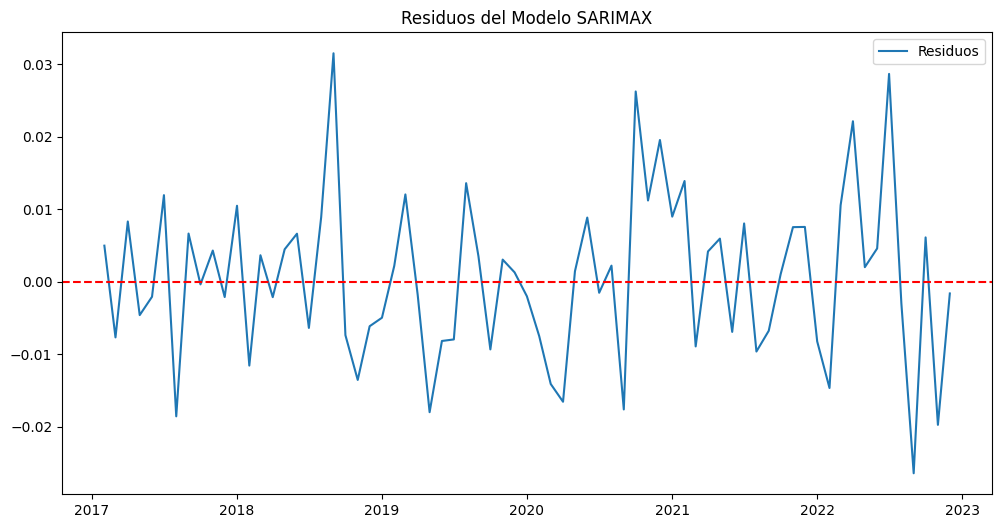

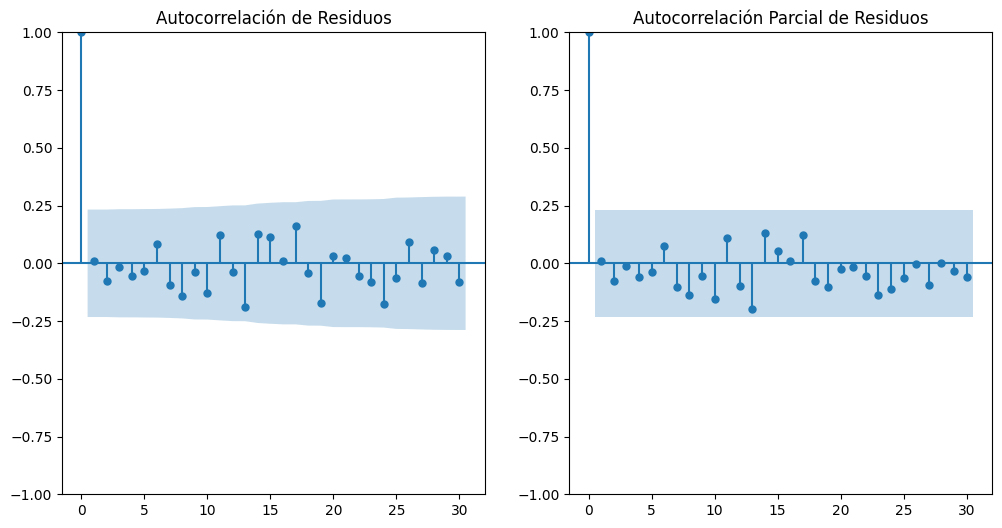

      lb_stat  lb_pvalue
1    0.007128   0.932716
2    0.470046   0.790553
3    0.487355   0.921661
4    0.710810   0.949989
5    0.806990   0.976585
6    1.376582   0.967267
7    2.089125   0.954743
8    3.773225   0.876982
9    3.892333   0.918355
10   5.291816   0.870852
11   6.575342   0.832358
12   6.692314   0.877259
13   9.953420   0.697739
14  11.407831   0.653742
15  12.561207   0.636149
16  12.568782   0.703987
17  15.132134   0.585965
18  15.322360   0.639727
19  18.326373   0.500746
20  18.424239   0.559483
21  18.488382   0.617923
22  18.795349   0.657929
23  19.490777   0.672401
24  22.841537   0.529168
25  23.271025   0.561741
26  24.270087   0.560524
27  25.127702   0.567305
28  25.554655   0.597509
29  25.674063   0.642850
30  26.512958   0.648712


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf

residuos = resultado_sarimax.resid

plt.figure(figsize=(12, 6))
plt.plot(residuos, label='Residuos')
plt.axhline(0, color='r', linestyle='--')
plt.legend()
plt.title('Residuos del Modelo SARIMAX')
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(121)
sm.graphics.tsa.plot_acf(residuos, lags=30, ax=plt.gca())
plt.title('Autocorrelación de Residuos')
plt.subplot(122)
sm.graphics.tsa.plot_pacf(residuos, lags=30, ax=plt.gca())
plt.title('Autocorrelación Parcial de Residuos')
plt.show()

ljung_box_residuos_SARIMAX = sm.stats.acorr_ljungbox(residuos, lags=30, return_df=True)
print(ljung_box_residuos_SARIMAX)


Text(0, 0.5, 'P-valores ')

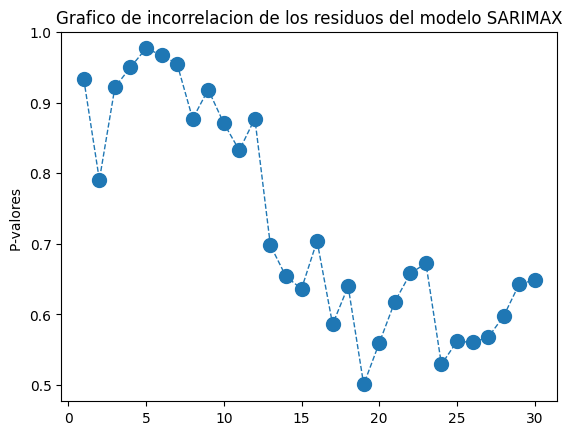

In [ ]:
Incorr_residuos_modelo_ARMA=sm.stats.acorr_ljungbox(resultado_sarimax.resid, lags=30)
plt.plot(Incorr_residuos_modelo_ARMA.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
plt.title("Grafico de incorrelacion de los residuos del modelo SARIMAX")
plt.ylabel("P-valores ")

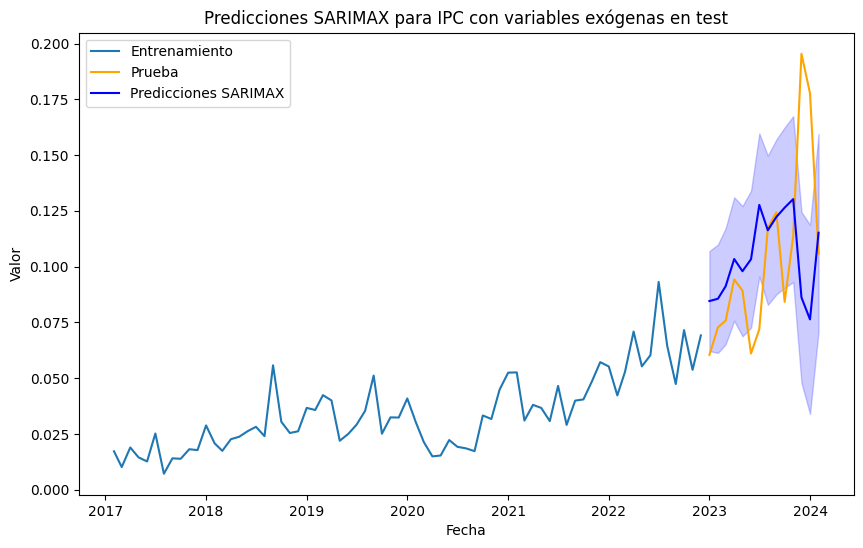

Métricas SARIMAX:
MSE: 0.002172700185986642
RMSE: 0.04661223214979778
MAE: 0.0321633241647707
MAPE: 30.9558005207465


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error


exog_train = pd.concat([df_alimentos_bebidas_subset['AlimentosBebidas'], df_bienes_subset['Bienes'], df_servicios_subset['Servicios']], axis=1).loc[train3.index]
exog_test = pd.concat([df_alimentos_bebidas_subset['AlimentosBebidas'], df_bienes_subset['Bienes'], df_servicios_subset['Servicios']], axis=1).loc[test3.index]

modelo_sarimax = sm.tsa.SARIMAX(train3,
                                exog=exog_train,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12))

resultado_sarimax = modelo_sarimax.fit()

steps = len(test3)
pred_sarimax = resultado_sarimax.get_forecast(steps=steps, exog=exog_test)

pred_conf_int_sarimax = pred_sarimax.conf_int()

plt.figure(figsize=(10, 6))
plt.plot(train3.index, train3, label='Entrenamiento')
plt.plot(test3.index, test3, label='Prueba', color='orange')
plt.plot(pred_sarimax.predicted_mean.index, pred_sarimax.predicted_mean, label='Predicciones SARIMAX', color='blue')
plt.fill_between(pred_conf_int_sarimax.index, pred_conf_int_sarimax.iloc[:, 0], pred_conf_int_sarimax.iloc[:, 1], color='blue', alpha=0.2)
plt.title('Predicciones SARIMAX para IPC con variables exógenas en test')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

mse_sarimax = mean_squared_error(test3, pred_sarimax.predicted_mean)
rmse_sarimax = np.sqrt(mse_sarimax)
mae_sarimax = mean_absolute_error(test3, pred_sarimax.predicted_mean)
mape_sarimax = np.mean(np.abs((test3 - pred_sarimax.predicted_mean) / test3)) * 100

print(f'Métricas SARIMAX:\nMSE: {mse_sarimax}\nRMSE: {rmse_sarimax}\nMAE: {mae_sarimax}\nMAPE: {mape_sarimax}')


modelo  SARIMA (0,1,1)(0,1,1)[12]

MSE: 0.002280426800075636 <br>
MAE: 0.03502640745660057  <br>
RMSE: 0.047753814508116894  <br>
MAPE: 0.2838 <br>


Modelo ARIMA(0, 1, 1)

MSE: 0.003076515261156358  <br>
MAE: 0.04000688284483166  <br>
RMSE: 0.05546634349906579  <br>
MAPE: 0.3153  <br>


" El modelo SARIMAX parece ser el mejor modelo basado en las métricas de MSE, MAE y RMSE "